# Import Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string 
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# from keras.models import Sequential
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier


import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import pickle 

In [34]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [35]:
# read csv file into pandas
df = pd.read_csv("../datasets/question8.csv")
df.head(3)

,question_id,answer,grade
0,8,643م - 709م,2
1,8,القرن السابع,2
2,8,القرن الثالث,0


# EDA

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  86 non-null     int64 
 1   answer       86 non-null     object
 2   grade        86 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ KB


In [37]:
df.groupby('grade').size()

grade
0    30
1    23
2    33
dtype: int64

In [38]:
df.duplicated().sum()

18

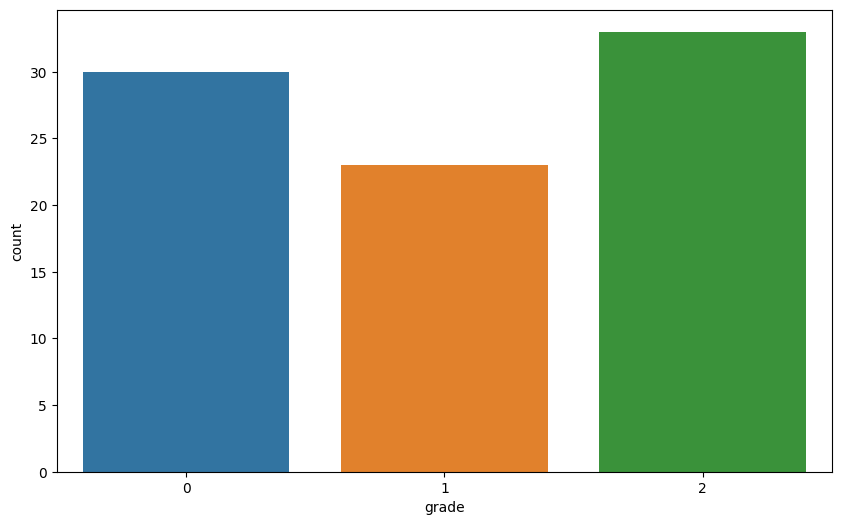

In [39]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.show()

# Data Cleaning

In [40]:
df.drop('question_id', axis=1, inplace=True)

In [41]:
df.dropna(inplace=True)

In [42]:
df.drop_duplicates(inplace=True)

# Data Pre-Preocessing

In [43]:
def txt_preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    #tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

In [44]:
df['tokens'] = df['answer'].apply(txt_preprocess)

# Text Representation

In [45]:
model_word2vec = Word2Vec(df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

In [46]:
def get_word_vector(tokens, model_word2vec):
    textvector = np.zeros((100,), dtype='float32')
    for token in tokens:
        try:
            textvector += model_word2vec.wv[token]
        except KeyError:
            continue
    return textvector


df['textvector'] = df['tokens'].apply(lambda x: get_word_vector(x, model_word2vec))

In [47]:
df.head()

,answer,grade,tokens,textvector
0,643م - 709م,2,"[643م, -, 709م]","[0.024262931, 0.0033126278, -0.014880531, -0.0..."
1,القرن السابع,2,"[القرن, السابع]","[0.0077785645, -0.0037653793, 0.0040574693, 0...."
2,القرن الثالث,0,"[القرن, الثالث]","[0.0015594547, 0.008713241, -0.0031978665, 0.0..."
4,القرن الخامس,0,"[القرن, الخامس]","[0.0046465937, -0.0039713774, -0.004082026, -0..."
5,من ٦٤٣م الى ٧١٥م,1,"[من, ٦٤٣م, الى, ٧١٥م]","[0.015998516, -0.00400648, 0.01811508, 0.01172..."


# split the data

In [48]:
train_data = df.sample(frac=0.85, random_state=42)
test_data = df.drop(train_data.index)

In [49]:
X_train = np.array(train_data['textvector'].tolist())
Y_train = np.array(train_data['grade'])

X_test = np.array(test_data['textvector'].tolist())
Y_test = np.array(test_data['grade'])
print(X_test)

[[-3.09541821e-04 -3.52380378e-03  5.02432790e-03  6.89765625e-03
  -1.11213308e-02 -8.82127695e-03  1.09852049e-02  1.37699060e-02
  -1.82892065e-02 -3.18379793e-03  1.06520560e-02  2.30834237e-03
   9.62865725e-03  7.72009604e-04 -8.49328749e-03  1.44748576e-03
   1.17127253e-02 -8.85700155e-03 -4.14713006e-03 -2.61040293e-02
   1.33562237e-02 -3.70124122e-04  2.34664902e-02 -8.51176493e-03
  -9.97671764e-03 -7.56667415e-03 -5.64558152e-03  6.79305010e-03
  -1.00310100e-03  9.17180069e-03 -8.16733949e-03  3.48752923e-03
   2.17638928e-02  8.30323994e-03  1.57353515e-03  1.04355048e-02
   1.08503411e-03 -4.94045159e-03 -7.01513560e-03 -4.78848349e-03
  -4.35864879e-03  1.48402923e-03 -1.74212884e-02  2.86310399e-03
  -6.98994473e-03 -1.10997725e-02 -4.35644761e-03  1.50220061e-03
   5.32004656e-03  9.93969198e-03 -1.08416257e-02  6.31122012e-03
  -1.18568381e-02  4.42648726e-03  8.67468119e-03  4.02033649e-04
  -5.75980172e-04 -1.17320726e-02 -5.36909979e-03  2.97022937e-03
  -1.00945

# build Models 

In [50]:
def getModel(name):
    if name == 'svm_linear':
        model_svm_linear = SVC(kernel='linear' ,probability=True)
        model_svm_linear.fit(X_train, Y_train)
        return model_svm_linear
    elif name == 'svm_rbf':
        model_svm_rbf = SVC(kernel='rbf' , probability=True)
        model_svm_rbf.fit(X_train, Y_train)
        return model_svm_rbf
    elif name == 'random_forest':
        model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        model_rf.fit(X_train, Y_train)
        return model_rf
    elif name == 'knn':
        model_knn = KNeighborsClassifier(n_neighbors=3)
        model_knn.fit(X_train, Y_train)
        return model_knn
    elif name == 'naive_bayes':
        model_nb = GaussianNB()
        model_nb.fit(X_train, Y_train)
        return model_nb
    elif name == 'bagging':
        # Créer le modèle de base
        base_model = KNeighborsClassifier(n_neighbors=3)
        model_bagging = BaggingClassifier(base_estimator=base_model, n_estimators=10, random_state=42)
        # Entraîner le modèle Bagging
        model_bagging.fit(X_train, Y_train)
        return model_bagging
    elif name == 'ann':
        # MLP: création + entrainement
        model_ANN = MLPClassifier(hidden_layer_sizes=(15, 10), random_state=1, max_iter=800)
        model_ANN.fit(X_train , Y_train)
        return model_ANN
    else:
        raise ValueError("Invalid model name. Please choose from 'svm', 'random_forest', 'knn', or 'naive_bayes'.")


In [51]:
# construire le model 
model_svm_lin = getModel('svm_linear')
# predire les donnees de Test
Y_pred_svm_lin = model_svm_lin.predict_proba(X_test)

In [52]:
# construire le model 
model_svm_rbf = getModel('svm_rbf')
# predire les donnees de Test
Y_pred_svm_rbf = model_svm_rbf.predict_proba(X_test)

In [53]:
# construire le model 
model_rf = getModel('random_forest')
# predire les donnees de Test
Y_pred_rf = model_rf.predict_proba(X_test)

In [54]:
# construire le model 
model_knn = getModel('knn')
# predire les donnees de Test
Y_pred_knn = model_knn.predict_proba(X_test)

In [55]:
# construire le model 
model_nb = getModel('naive_bayes')
# predire les donnees de Test
Y_pred_nb = model_nb.predict_proba(X_test)

In [56]:
# construire le model 
model_ann = getModel("ann")
# predire les donnees de Test
Y_pred_ann = model_ann.predict_proba(X_test)

In [57]:
# construire le model 
model_bagging  = getModel('bagging')
# predire les donnees de Test
Y_pred_bagging = model_bagging.predict_proba(X_test)

# Models Evaluation

In [58]:
models = [
  getModel('svm_linear'),
  getModel('svm_rbf'),
  getModel('random_forest'),
  getModel('knn'),
  getModel('naive_bayes'),
  getModel("ann"),
  getModel('bagging')
]
models_names = [
    'SVM Linear',
    'SVM RBF',
    'Random Forest',
    'KNN',
    'Naive Bayes',
    'ANN',
    'Ensemble Learning (Bagging)'
]
predicted_Xtest_proba = [
    Y_pred_svm_lin,
    Y_pred_svm_rbf,
    Y_pred_rf,
    Y_pred_knn,
    Y_pred_nb,
    Y_pred_ann,
    Y_pred_bagging
]

In [59]:
def getAccuracy(models):
  accuracies = []
  for model in models:
    Y_Test_predi = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_Test_predi)
    accuracies.append(accuracy)

  return accuracies

In [60]:
accuracies = getAccuracy(models)
i=0
for model in models_names:
    print(f"accuracy {model} :  {accuracies[i]}")
    i += 1

accuracy SVM Linear :  0.6
accuracy SVM RBF :  0.7
accuracy Random Forest :  0.8
accuracy KNN :  0.7
accuracy Naive Bayes :  0.7
accuracy ANN :  0.8
accuracy Ensemble Learning (Bagging) :  0.8


In [61]:
i=0
for  Y_test_pred_prob in predicted_Xtest_proba:
#     Y_test_pred = Y_test_pred.reshape(-1, 1)
    auc_roc = roc_auc_score(Y_test, Y_test_pred_prob , multi_class='ovr')
    print(f"{models_names[i]}  Aire sous la courbe ROC:", auc_roc)
    i += 1

SVM Linear  Aire sous la courbe ROC: 0.8125
SVM RBF  Aire sous la courbe ROC: 0.951388888888889
Random Forest  Aire sous la courbe ROC: 0.9097222222222223
KNN  Aire sous la courbe ROC: 0.9409722222222223
Naive Bayes  Aire sous la courbe ROC: 0.8611111111111112
ANN  Aire sous la courbe ROC: 0.9652777777777778
Ensemble Learning (Bagging)  Aire sous la courbe ROC: 1.0


# the best Model

In [62]:
max_index = np.argmax(accuracies)
best_model = models[max_index]

In [63]:
pd.DataFrame({"Real ": Y_test , "Predicted" : best_model.predict(X_test)})

,Real,Predicted
0,0,0
1,2,1
2,2,0
3,1,1
4,2,2
5,1,1
6,2,2
7,0,0
8,2,2
9,2,2


# saving the best model

In [64]:
model_path = '../saved_models/model_question8.h5'
with open(model_path, 'wb') as file:
    pickle.dump((best_model, model_word2vec), file)

# Test Model

In [65]:
i=1
while True:
    print("--------------  Testing  ---------------")
    
    answer = input('الاجابه: ')
    process = txt_preprocess(answer)
    txt = get_word_vector(process, model_word2vec)
    txt = txt.reshape(1, -1)
    predicted_ques = best_model.predict(txt)[0]
    print(f'Grade of Answer Is : {predicted_ques}')
    
    exit = int(input("Enter Zero To Exit From System  OR One To Run The Program : \n"))
    if exit == 0:
        print('Exit From System...','Thank You')
        break
    else:
        continue   
        print('\n')

--------------  Testing  ---------------


KeyboardInterrupt: Interrupted by user